Status plot created


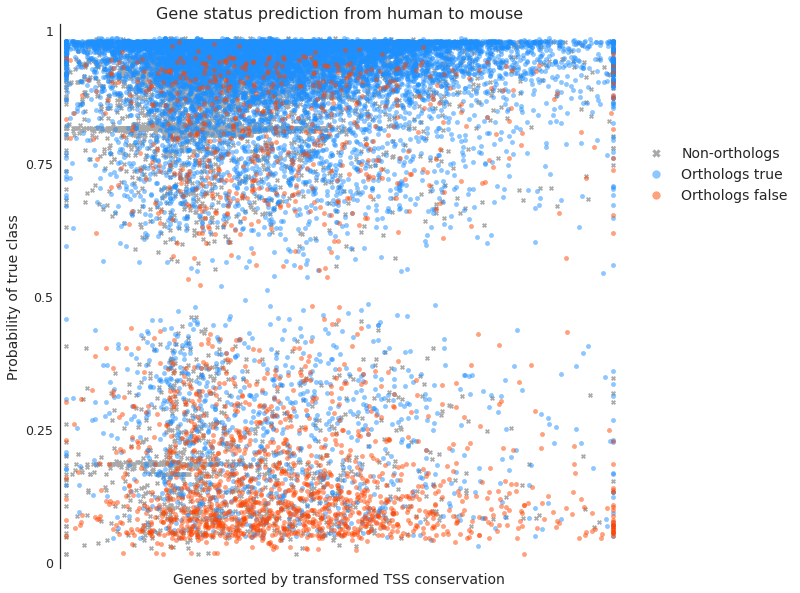

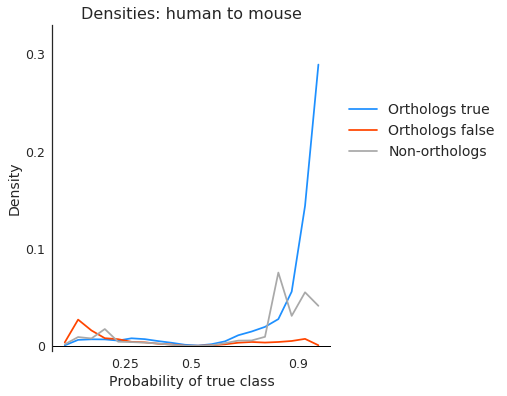

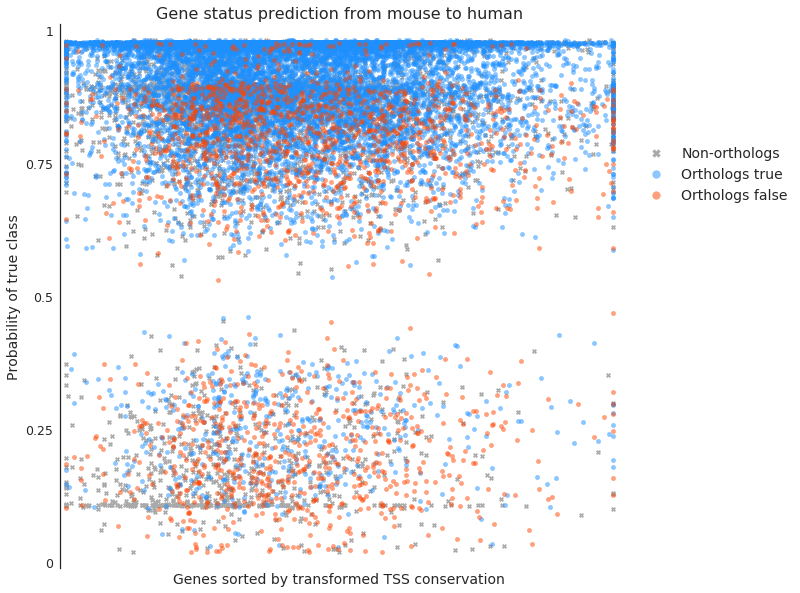

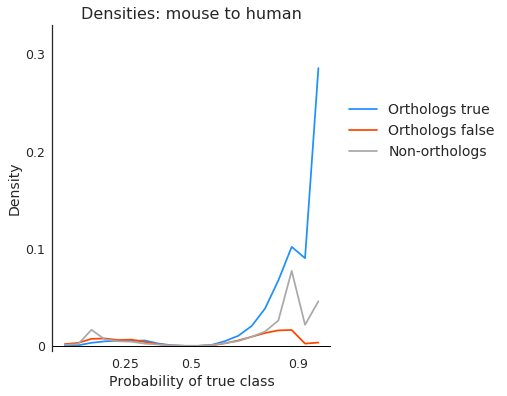

In [52]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import scoreatpercentile as pctscore

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
ortho_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(ortho_folder, 'orthopred_odb_v9.h5')

cache_dir = '/home/pebert/.jupyter/cache'

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))

run_exec_status = True

show_figures = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

def exec_status():
    cache_data = os.path.join(cache_dir, 'plot_perf_status_scatter.pck')
    if not run_exec_status:
        return False
    if os.path.isfile(cache_data):
        model_perf = pck.load(open(cache_data, 'rb'))
    else:
        model_perf = collect_ortho_perf(ortho_pred, 'can')
        model_perf = collect_model_stat_perf(stat_file, model_perf, 'pos', 'can')
        with open(cache_data, 'wb') as out:
            print('Writing cache file for status scatter plot')
            pck.dump(model_perf, out)
    for (spec_a, spec_b), perf in model_perf.items():
        
        colors = ['dodgerblue', 'orangered', 'darkgrey']
        
        orth_true, orth_false, non_orth = prepare_scatter_points(perf['model_perf'], perf['ortho_perf'], 'binary')
        
        fig, exart = plot_perf_scatter(orth_true, orth_false, non_orth,
                                       'binary', colors,
                                       'Genes sorted by transformed TSS conservation', 'Probability of true class',
                                       'Gene status prediction from {} to {}'.format(spec_a, spec_b))
        if save_figures:
            outpath = os.path.join(out_folder, 'main', 'fig_X_main_{}-to-{}_testperf_scatter.svg'.format(spec_a, spec_b))
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            outpath = outpath.replace('.svg', '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
            
        fig, exart = plot_density([v[1] for v in orth_true],
                                  [v[1] for v in orth_false],
                                  [v[1] for v in non_orth], colors, 'Probability of true class', 'Density',
                                  'Densities: {} to {}'.format(spec_a, spec_b))
        
        if save_figures:
            outpath = os.path.join(out_folder, 'main', 'fig_X_main_{}-to-{}_testperf_density.svg'.format(spec_a, spec_b))
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            outpath = outpath.replace('.svg', '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)

    return True
 

def plot_density(orth_true, orth_false, non_orth, colors, xlabel, ylabel, title):
    """
    """
    fig, ax = plt.subplots(figsize=(5, 6))
    ax.set_ylim(-0.005, 0.33)
    bins = np.arange(0, 1.05, 0.05)
    x_coords = np.arange(0.025, 1., 0.05)
    counts = np.zeros((3, len(bins) - 1), dtype=np.float32)
    counts[0, :] = np.histogram(orth_true, bins)[0]
    counts[1, :] = np.histogram(orth_false, bins)[0]
    counts[2, :] = np.histogram(non_orth, bins)[0]
    total = counts.sum()
    counts /= total
    
    ax.plot(x_coords, counts[0,:], color=colors[0], label='Orthologs true')
    ax.plot(x_coords, counts[1,:], color=colors[1], label='Orthologs false')
    ax.plot(x_coords, counts[2,:], color=colors[2], label='Non-orthologs')
    
    ax.axhline(linestyle='-', color='black', linewidth=1)
    
    ax.set_yticks([0, 0.1, 0.2, 0.3])
    ax.set_yticklabels(['0', '0.1', '0.2', '0.3'])
    
    ax.set_xticks([0.25, 0.5, 0.9])
    ax.set_xticklabels(['0.25', '0.5', '0.9'])
    
    handles, labels = ax.get_legend_handles_labels()
    leg = ax.legend(handles, labels, markerscale=1.75, fontsize=14, bbox_to_anchor=(1.02, 0.8))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    
    exart = [leg]
    
    return fig, exart
    
    

def plot_perf_scatter(orth_true, orth_false, non_orth, variant, colors, xlabel, ylabel, title):
    """
    """
    model_color = colors[2]
    fig, ax = plt.subplots(figsize=(10, 10))
    if variant == 'binary':
        ax.set_xlim(-0.01, 1.01)
        ax.set_ylim(-0.01, 1.01)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
        ax.set_yticklabels([0, 0.25, 0.5, 0.75, 1])
        scats = [non_orth, orth_true, orth_false]
        scat_colors = [colors[2], colors[0], colors[1]]
        plot_labels = ['Non-orthologs', 'Orthologs true', 'Orthologs false']
    elif variant == 'steps':
        ax.set_xlim(-0.505, 0.505)
        ax.set_ylim(-0.505, 0.505)
        ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
        ax.set_xticklabels([1, 0.75, 0.5, 0.75, 1])
        ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
        ax.set_yticklabels([1, 0.75, 0.5, 0.75, 1])
        scats = [orth_true, orth_false]
        scat_colors = [colors[0], colors[1]]
    else:
        raise NotImplementedError()
    
    for s, c, l in zip(scats, scat_colors, plot_labels):
        if c == model_color:
            ax.scatter([x[0] for x in s], [y[1] for y in s], s=20, c=c, marker='X',
                       label=l)
        else:
            ax.scatter([x[0] for x in s], [y[1] for y in s], s=20, c=c, alpha=0.5,
                       label=l)
    
    handles, labels = ax.get_legend_handles_labels()
    leg = ax.legend(handles, labels, markerscale=1.75, fontsize=14, bbox_to_anchor=(1.02, 0.8))

    extra_artists = [leg]
    
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    return fig, extra_artists


def transform_cons_scores(scores):
    """
    """
    cons = np.array([s[1] for s in scores], dtype=np.float32)
    names = [s[0] for s in scores]
    min_cons = cons.min()
    adj_cons = cons + np.abs(min_cons) + 1
    pct_min = pctscore(adj_cons, 1)
    adj_cons[adj_cons <= pct_min] = pct_min
    pct_max = pctscore(adj_cons, 99)
    adj_cons[adj_cons >= pct_max] = pct_max
    adj_cons = np.log2(adj_cons)
    adj_cons = (adj_cons - adj_cons.min()) / (adj_cons.max() - adj_cons.min())
    assert adj_cons.min() == 0., 'Norm failed'
    assert adj_cons.max() == 1., 'Norm failed'
    lut = dict((g, c) for g, c in zip(names, adj_cons))
    return lut


def prepare_scatter_points(model, ortho, variant):
    """
    """
    non_orth = []
    orth_true = []
    orth_false = []
    cons_scores = transform_cons_scores([(gene, vals['cons']) for gene, vals in model.items()])
    for gene, vals in model.items():
        #x = vals['cons']
        x = cons_scores[gene]
        vote = 1 if vals['true'] > vals['false'] else -1
        probs = np.array(vals['prob'], dtype=np.float32)
        labels = np.array(vals['label'], dtype=np.int8)
        if vals['true'] == vals['false']:
            # break tie
            pos_mean = np.mean(probs[labels == 1])
            neg_mean = np.mean(probs[labels == -1])
            if pos_mean > neg_mean:
                vote = 1
                y = pos_mean
            else:
                vote = -1
                y = neg_mean
        else:
            y = np.mean(probs[labels == vote])
        orth_vals = ortho[gene]
        if not orth_vals:
            non_orth.append((x, y))
            continue
        else:
            vote = 1 if orth_vals['true'] > orth_vals['false'] else -1
            if orth_vals['true'] == orth_vals['false']:
                dists = np.array(orth_vals['dist'], dtype=np.float32)
                labels = np.array(orth_vals['label'], dtype=np.int8)
                pos_dist = np.mean(dists[labels == 1])
                neg_dist = np.mean(dists[labels == -1])
                if pos_dist > neg_dist:
                    vote = 1
                else:
                    vote = -1
            if variant == 'binary':
                if vote > 0:
                    orth_true.append((x, y))
                else:
                    orth_false.append((x, y))
            elif variant == 'steps':
                model_x = y
                total = len(orth_vals['label'])
                if vote > 0:
                    orth_y = (orth_vals['true'] / total) - 0.5
                else:
                    orth_y = -1 * (orth_vals['false'] / total) + 0.5
                x, y = model_x, orth_y
                if vote > 0:
                    orth_true.append((x, y))
                else:
                    orth_false.append((x, y))
            else:
                raise NotImplementedError()
    assert non_orth, 'Model only empty'
    assert orth_true, 'Orth. true empty'
    assert orth_false, 'Orth. false empty'
    return orth_true, orth_false, non_orth
        


def collect_ortho_perf(fpath, model):
    """
    """
    collector = dict()
    with pd.HDFStore(fpath, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.startswith('/pos/pair') and k.endswith('/data')]
        for k in load_keys:
            if any([c in k for c in ['GM12878', 'CH12', 'K562', 'MEL']]):
                continue
            parts = k.split('/')
            spec_a, spec_b = parts[3], parts[4]
            spec_b_name = spec_b + '_name'
            if (spec_a, spec_b) not in [('mouse', 'human'), ('human', 'mouse')]:
                continue
            perf = hdf[k]
            # that is a bit shaky, but works
            tpm_cols = [c for c in perf.columns if c.startswith('T') and not c.endswith('rank')]
            perf['tpm1'] = perf[tpm_cols[0]]
            perf['tpm2'] = perf[tpm_cols[1]]
            perf['name'] = perf[spec_b_name]
            if (spec_a, spec_b) not in collector:
                init = False
                collector[(spec_a, spec_b)] = {'ortho_perf': col.defaultdict(dict),
                                               'model_perf': col.defaultdict(dict)}
            perf['true'] = perf.loc[:, ['true_pos', 'true_neg']].sum(axis=1)
            perf['false'] = perf.loc[:, ['false_pos', 'false_neg']].sum(axis=1)
            data_collect = collector[(spec_a, spec_b)]['ortho_perf']
            if init:
                for row in perf.itertuples():
                    data_collect[row.name]['true'] += row.true
                    data_collect[row.name]['false'] += row.false
                    data_collect[row.name]['label'].append(1 if row.true > 0 else -1)
                    d = ((row.tpm1 + row.tpm2) / 2) - 1
                    data_collect[row.name]['dist'].append(d)
            else:
                for row in perf.itertuples():
                    data_collect[row.name]['cons'] = row.cons_score
                    data_collect[row.name]['true'] = row.true
                    data_collect[row.name]['false'] = row.false
                    data_collect[row.name]['label'] = [1 if row.true > 0 else -1]
                    d = ((row.tpm1 + row.tpm2) / 2) - 1
                    data_collect[row.name]['dist'] = [d]
                init = True
    return collector


def collect_model_stat_perf(fpath, data_collect, scenario, model_type):
    """
    """
    with pd.HDFStore(fpath, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.startswith('/'.join(['', scenario, model_type])) and k.endswith('/data')]
        for k in load_keys:
            if any([c in k for c in ['GM12878', 'CH12', 'K562', 'MEL']]):
                continue
            md = hdf[k.replace('/data', '/metadata')]
            spec_a = md.loc['target_spec',:][0]
            spec_b = md.loc['query_spec',:][0]
            if (spec_a, spec_b) not in [('human', 'mouse'), ('mouse', 'human')]:
                continue
            perf = hdf[k]
            perf['name'] = perf.index
            collect = data_collect[(spec_a, spec_b)]['model_perf']
            if len(collect.keys()) > 1:
                for row in perf.itertuples():
                    fac = 1 if (row.tp + row.tn) > 0 else -1
                    prob = row.true_class_prob
                    collect[row.name]['true'] += 1 if fac > 0 else 0
                    collect[row.name]['false'] += 1 if fac < 0 else 0
                    collect[row.name]['label'].append(fac)
                    collect[row.name]['prob'].append(prob)
            else:
                for row in perf.itertuples():
                    fac = 1 if (row.tp + row.tn) > 0 else -1
                    prob = row.true_class_prob
                    collect[row.name]['true'] = 1 if fac > 0 else 0
                    collect[row.name]['false'] = 1 if fac < 0 else 0
                    collect[row.name]['label'] = [fac]
                    collect[row.name]['prob'] = [prob]
                    collect[row.name]['cons'] = row.cons_score
                init = True
    return data_collect  

execd = exec_status()
if execd:
    print('Status plot created')